In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial.transform import Rotation 
from scipy.optimize import minimize

In [59]:
class Dish:
    def __init__(self, f, dphi, r0, r1):
        self.set_params(f, dphi, r0, r1)
    def set_params(self, f, dphi, r0, r1):
        f = np.abs(f)
        self.f = f
        self.dphi = dphi
        self.r0 = r0
        self.r1 = r1
        ## petal from center, upring
        points_pet = [ (4,4), (5,3), (5,2), (5,1), (0,1), (-5,1), (-5,2), (-5,3), (-4,4)]
        dphi_rad = dphi/180*np.pi
        
        points_xyz = [self.get_point_dish_surface(petal, upright) for petal,upright in points_pet]
        self.points_xyz = points_xyz
        self.focal = np.array([0,0,f])
        self.dishcenter = self.get_point_dish_surface(0,3)
    
    def get_point_dish_surface(self, petal, upright):
        dphi_rad = self.dphi/180*np.pi

        r = self.r0+(upright-1)*self.r1
        x = r*np.sin(dphi_rad*petal)
        y = r*np.cos(dphi_rad*petal)
        z = r*r/(4*np.abs(self.f))
        #print (r,x,y,z,dphi_rad, petal, upright)
        #stop()
        return np.array([x,y,z])
    
    def plot_petals(self, ax):
        for petal in range(6):
            maxupright = 5 if petal<=3 else 4
            
            # plot the petal to the right
            points_right = [(petal,1),(petal,maxupright), (petal+1, maxupright), (petal+1,1)]   
            points_left = [(-petal,1),(-petal,maxupright), (-petal-1, maxupright), (-petal-1,1)]
            
            polygon_right = [self.get_point_dish_surface(p,u)[:2] for p,u in points_right]
            polygon_left = [self.get_point_dish_surface(p,u)[:2] for p,u in points_left]
            
            polygon = Polygon(polygon_right, closed = True, edgecolor = 'black', linewidth = .3, facecolor = 'lavender')
            ax.add_patch(polygon)
            polygon = Polygon(polygon_left, closed = True, edgecolor = 'black', linewidth = .3, facecolor = 'lavender')
            ax.add_patch(polygon)
        #now plot uprights
        for upright in range(2,5):
            petals = range(-6,7) if upright<4 else range(-4,5)
            x= [self.get_point_dish_surface(petal,upright)[0] for petal in petals]
            y= [self.get_point_dish_surface(petal,upright)[1] for petal in petals]
            plt.plot(x,y,'k:')
        plt.plot(self.dishcenter[1], 'ro', markersize = 10)
        plt.xlim(-300, 300)
        plt.ylim(0, 500)
        
    def plot_horn_proj(self, horn, ax):
        p1,p2,p3,p4 = horn.points_xyz
        pc = (p1+p2+p3+p4)/4
        pnorm = np.cross(p2-p1, p3-p1)
        #quadratic equation for lambda has
        A = pnorm[0]**2+pnorm[1]**2
        B = 2*(pc[0]*pnorm[0]+pc[1]*pnorm[1]-2*self.f*pnorm[2])
        C = pc[0]**2+pc[1]**2-4*self.f*pc[2]
        # solution to quadratic equation
        lam = (-B + np.sqrt(B*B-4*A*C))/(2*A) # need to pick the right solution
        xp,yp,_ = pc + lam*pnorm
        plt.plot(xp,yp,'bo', markersize = 10)


class Horn:
    def __init__(self, Dish, alpha, beta, gamma, xp, yp, zp):
        self.Dish = Dish
        self.set_params(alpha,beta,gamma, xp, yp, zp )
    def set_params(self,alpha,beta,gamma, xp, yp, zp):
        dh = 69.0
        dv = 69.1
        ## lookin down from the focal point
        p1 = np.array([-dh/2,+dv/2,0]) #corners of the horn
        p2 = np.array([+dh/2,+dv/2,0])
        p3 = np.array([+dh/2,-dv/2,0])
        p4 = np.array([-dh/2,-dv/2,0])
        R = Rotation.from_euler('zyx',[alpha,beta,gamma],degrees=True).as_matrix()   # rotates it by an angle
        ofs = np.array([xp,yp,zp])
        points_pxyz = [np.dot(R,p)+ofs for p in [p1,p2,p3,p4]]
        # points_pxyz is in the coordinate system looking down from the focal 
        # point of the dish at the center of the dish surface
        # we now need to transform this to the dish coordinate system
        znormal = self.Dish.dishcenter-self.Dish.focal
        znormal /= np.sqrt((znormal**2).sum())
        xnormal = np.array([1,0,0])
        ynormal = np.cross(xnormal,znormal)
#         print (xnormal, ynormal, znormal)
        points_xyz = [self.Dish.focal+v[0]*xnormal+v[1]*ynormal+v[2]*znormal for v in points_pxyz]
#         print (points_xyz)
        self.points_xyz = points_xyz
        
class Fitter:
    def __init__(self, data, vec, fixdish = False):
        self.data = data
        self.vec = vec
        self.fixdish = fixdish
        
    def predict_measurements(self, vec):
        D = Dish(*vec[:4])
        pD = D.points_xyz
        H = Horn(D, *vec[4:])
        pH = H.points_xyz
        def dist(p1,p2):
            return np.sqrt(np.sum((p1-p2)**2))
        pred = np.array([[dist(p1,p2) for p1 in pH] for p2 in pD])
        return pred
        
    def chi2(self, vec):
        pred = self.predict_measurements(vec)
        dchisq = (pred-self.data)**2/sigma**2
        dchisq[self.data < 0] = 0.0 # negative numbers won't add to chi2
        chisq = dchisq.sum()
        return chisq
    
    def chi2_horn_only(self, vec):
        vec[0] = 290
        vec[1] = 8
        vec[2] = 70
        vec[3] = 100
        pred = self.predict_measurements(vec)
        dchisq = (pred-self.data)**2/sigma**2
        dchisq[self.data < 0] = 0.0 # negative numbers won't add to chi2
        chisq = dchisq.sum()
        return chisq

    def fit(self):
        if self.fixdish:
            fit_min = minimize(self.chi2_horn_only, self.vec)
        else:
            fit_min = minimize(self.chi2, self.vec)
        return fit_min

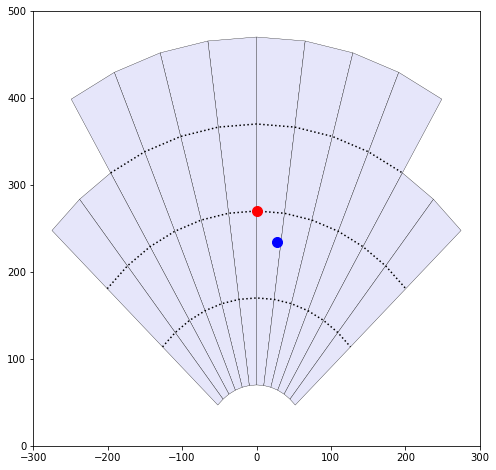

In [37]:
start = np.array([290., 8., 70., 100., 0, 0, 0, 0, 0, 20])
D = Dish(*start[:4])
## lets displace it a little, if you set those to zero it overlaps with red
start[7]=5
start[8]=10
start[5]=4
start[6]=8
H = Horn(D, *start[4:])
fig, ax = plt.subplots(1, figsize = (8,8))
D.plot_petals(ax)
D.plot_horn_proj(H,ax)

In [34]:
N_measurements = np.array([
    [376.6, 337.0, 353.2, 390.8],
    [331.3, 291.8, 284.1, 324.1],
    [296.7, 269.2, 240.1, 269.5],
    [282.3, 271.1, 222.5, 235.6],    
    [272.5, 272.7, 228.3, 227.9],
    [270.0, 282.0, 236.5, 221.7],
    [266.7, 293.8, 269.4, 238.3],
    [288.3, 327.1, 323.1, 283.3],
    [333.7, 372.1, 389.4, 353.0]
])

In [60]:
# f, dphi, r0, r1, alpha, beta, gamma, xp, yp, zp
start = np.array([290., 8., 70., 100., 0., 0., 0., 0., 0., 20.])
sigma = 0.3 ## sigma err in cm

N_fitter_T = Fitter(N_measurements, start, True)
N_fit_T = N_fitter_T.fit()
print('N_fit (Fixed Dish) = ', N_fit_T.fun)

N_fitter_F = Fitter(N_measurements, start, False)
N_fit_F = N_fitter_F.fit()
print('N_fit (Relaxed Dish) = ', N_fit_F.fun)

N_fit (Fixed Dish) =  73.5293734642444
N_fit (Relaxed Dish) =  32.48924929803589


In [61]:
pred_T = N_fitter_T.predict_measurements(N_fit_T.x)
pred_F = N_fitter_F.predict_measurements(N_fit_F.x)

print('Predicted measurements (Fixed):')
print(pred_T)
print('')
print('Predicted measurements (Relaxed):')
print(pred_F)

Predicted measurements (Fixed):
[[375.94552967 336.97884352 353.1430689  390.50009912]
 [330.89251254 292.08258949 284.56920227 324.279581  ]
 [296.37790239 269.96179186 240.46502828 269.7849547 ]
 [281.92713626 271.45355562 222.86205312 235.5066284 ]
 [272.02784671 272.68883569 228.16379687 227.37340759]
 [269.6199163  281.62310179 235.9693115  221.50585494]
 [267.12298986 294.17505472 269.12619717 239.25851896]
 [288.63043346 327.1190731  322.76395398 283.68505269]
 [334.2988258  371.56984215 388.47990627 352.99885965]]

Predicted measurements (Relaxed):
[[376.3674003  336.6492022  353.15656717 391.20237167]
 [331.12362218 291.62184969 284.10902508 324.52655989]
 [296.48000894 269.64738048 239.96969992 269.77053726]
 [282.23342126 271.70006467 222.90372656 235.62862781]
 [272.10820736 272.77117995 228.11491438 227.32174129]
 [269.86662261 281.93957835 236.10920445 221.55275801]
 [266.79404234 294.26742756 269.128735   238.7802716 ]
 [288.14561232 327.324794   323.02645599 283.2533572

Text(0.5, 0.98, 'North dish')

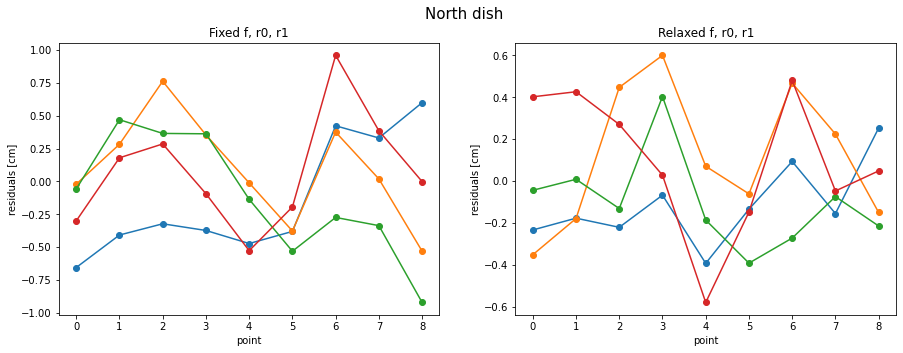

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.plot(N_fitter_T.predict_measurements(N_fit_T.x)-N_measurements,'-o')
ax1.set_title('Fixed f, r0, r1')
ax1.set_xlabel('point')
ax1.set_ylabel('residuals [cm]')

ax2.plot(N_fitter_F.predict_measurements(N_fit_F.x)-N_measurements,'-o')
ax2.set_title('Relaxed f, r0, r1')
ax2.set_xlabel('point')
ax2.set_ylabel('residuals [cm]')

plt.suptitle('North dish', size = 15)

In [63]:
resid_T = N_fitter_T.predict_measurements(N_fit_T.x)-N_measurements
resid_F = N_fitter_F.predict_measurements(N_fit_F.x)-N_measurements

print('rms_T = ',  np.sqrt(resid_T**2).mean())
print('rms_F = ',  np.sqrt(resid_F**2).mean())

rms_T =  0.36294870887881575
rms_F =  0.23395903267036763


In [64]:
vals_T = N_fit_T.x
errs=np.sqrt((N_fit_T.hess_inv.diagonal())*2)
names = 'f dphi r0 r1 alpha beta gamma xp yp zp'.split()
print('Fixed Dish:')
for n,v,e in zip(names,vals_T, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

print('')
vals_F = N_fit_F.x
print('Relaxed Dish:')
for n,v,e in zip(names,vals_F, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

Fixed Dish:
f = 290.00 +/- 1.41
dphi = 8.00 +/- 1.41
r0 = 70.00 +/- 1.41
r1 = 100.00 +/- 1.41
alpha = 1.79 +/- 0.03
beta = -0.09 +/- 0.05
gamma = 2.29 +/- 0.04
xp = -2.15 +/- 0.12
yp = -4.94 +/- 0.10
zp = 58.13 +/- 0.06

Relaxed Dish:
f = 288.45 +/- 1.41
dphi = 8.13 +/- 1.41
r0 = 69.57 +/- 1.41
r1 = 100.81 +/- 1.41
alpha = 1.80 +/- 0.03
beta = -0.11 +/- 0.05
gamma = 3.06 +/- 0.04
xp = -2.11 +/- 0.12
yp = -2.97 +/- 0.10
zp = 58.20 +/- 0.06


In [65]:
# E dish
E_measurements = np.array([
    [388.2, 348.8, 364.6, 401.6], 
    [341.5, 302.9, 296.0, 335.9], 
    [306.4, 278.4, 250.2, 280.9],
    [289.9, 276.8, 229.4, 245.1],
    [280.4, 277.8, 233.4, 235.7],
    [276.9, 286.0, 241.3, 229.9],
    [275.1, 299.1, 274.0, 247.1],
    [296.9, 332.4, 327.4, 291.3],
    [346.6, 381.9, 396.3, 362.7]
])

In [66]:
E_fitter_T = Fitter(E_measurements, start, True)
E_fit_T = E_fitter_T.fit()
print('E_fit (True)', E_fit_T.fun)

E_fitter_F = Fitter(E_measurements, start, False)
E_fit_F = E_fitter_F.fit()
print('E_fit (False)', E_fit_F.fun)

E_fit (True) 263.0441935288814
E_fit (False) 203.37245649098304


In [68]:
pred_T = E_fitter_T.predict_measurements(E_fit_T.x)
pred_F = E_fitter_F.predict_measurements(E_fit_F.x)

print('Predicted measurements (Fixed):')
print(pred_T)
print('')
print('Predicted measurements (Relaxed):')
print(pred_F)

Predicted measurements (Fixed):
[[388.06993044 349.15275728 364.97582733 402.36547756]
 [342.0437224  302.74236694 295.8350845  335.94547848]
 [306.28545584 278.41285481 250.08961135 280.78795638]
 [289.26952407 276.47389446 228.97660511 244.27306222]
 [279.87472105 277.94737128 234.0656045  236.35106407]
 [276.44260578 285.65283717 240.19569512 229.16575411]
 [276.02215948 300.07413802 274.45956309 247.93506406]
 [298.3373182  333.998133   328.36136662 292.01299572]
 [344.93207493 379.98895685 395.15100443 361.56720715]]

Predicted measurements (Relaxed):
[[388.02727181 349.27347435 365.63492811 402.81770621]
 [341.69799314 302.42208305 295.87069997 335.9134908 ]
 [305.93325135 278.01461698 249.57782335 280.34285604]
 [289.96305284 277.10233984 229.07643419 244.47674321]
 [280.15416467 278.2342062  233.73762409 236.0198284 ]
 [277.05075515 286.34114015 240.38151472 229.23600286]
 [275.61736608 299.7118467  273.9873962  247.40015099]
 [298.02437151 333.65206745 328.31725193 292.0394524

Text(0.5, 0.98, 'East dish')

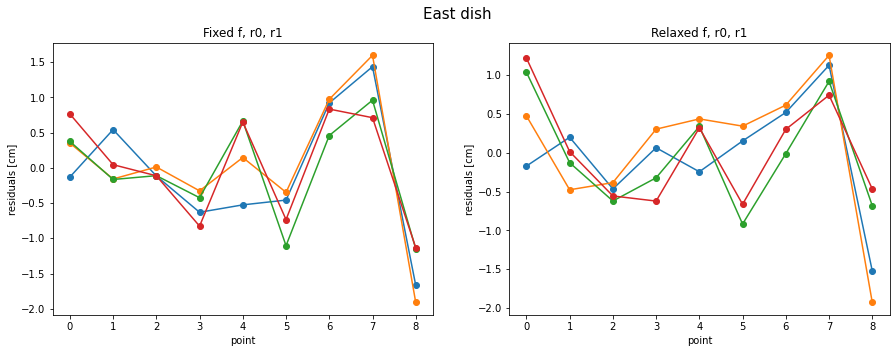

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.plot(E_fitter_T.predict_measurements(E_fit_T.x)-E_measurements,'-o')
ax1.set_title('Fixed f, r0, r1')
ax1.set_xlabel('point')
ax1.set_ylabel('residuals [cm]')

ax2.plot(E_fitter_F.predict_measurements(E_fit_F.x)-E_measurements,'-o')
ax2.set_title('Relaxed f, r0, r1')
ax2.set_xlabel('point')
ax2.set_ylabel('residuals [cm]')

plt.suptitle('East dish', size = 15)

In [70]:
resid_T = E_fitter_T.predict_measurements(E_fit_T.x)-E_measurements
resid_F = E_fitter_F.predict_measurements(E_fit_F.x)-E_measurements

print('rms_T = ',  np.sqrt(resid_T**2).mean())
print('rms_F = ',  np.sqrt(resid_F**2).mean())

rms_T =  0.6524041108785118
rms_F =  0.5707652468058207


In [71]:
vals_T = E_fit_T.x
errs=np.sqrt((E_fit_T.hess_inv.diagonal())*2)
names = 'f dphi r0 r1 alpha beta gamma xp yp zp'.split()
print('Fixed f, r0, r1:')
for n,v,e in zip(names,vals_T, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

print('')
vals_F = E_fit_F.x
print('Relaxed f, r0, r1:')
for n,v,e in zip(names,vals_F, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

Fixed f, r0, r1:
f = 290.00 +/- 1.41
dphi = 8.00 +/- 1.41
r0 = 70.00 +/- 1.41
r1 = 100.00 +/- 1.41
alpha = 0.48 +/- 0.01
beta = -1.07 +/- 0.01
gamma = 1.03 +/- 0.01
xp = -5.54 +/- 0.01
yp = -7.66 +/- 0.01
zp = 46.23 +/- 0.01

Relaxed f, r0, r1:
f = 299.17 +/- 1.41
dphi = 7.81 +/- 1.41
r0 = 72.04 +/- 1.41
r1 = 101.43 +/- 1.41
alpha = 0.46 +/- 0.01
beta = -1.06 +/- 0.01
gamma = 0.97 +/- 0.01
xp = -5.55 +/- 0.01
yp = -8.76 +/- 0.01
zp = 57.20 +/- 0.01


In [72]:
# S dish
S_measurements = np.array([
    [384.2, 346.8, 365.9, 401.1],
    [337.5, 298.6, 295.5, 334.2],
    [302.0, 274.4, 249.9, 279.4],
    [285.3, 273.8, 229.6, 243.5],
    [276.0, 275.9, 235.4, 235.8],
    [274.2, 285.4, 243.0, 229.7],
    [275.1, 299.9, 278.9, 250.4],
    [298.7, 336.8, 334.0, 296.6],
    [347.7, 384.2, 401.3, 367.9]
])

In [80]:
S_fitter_T = Fitter(S_measurements, start, True)
S_fit_T = S_fitter_T.fit()
print('S_fit (Fixed)', S_fit_T.fun)

S_fitter_F = Fitter(S_measurements, start, False)
S_fit_F = S_fitter_F.fit()
print('S_fit (Relaxed)', S_fit_F.fun)

S_fit (Fixed) 88.24790886722081
S_fit (Relaxed) 67.16799818170801


In [81]:
pred_T = S_fitter_T.predict_measurements(S_fit_T.x)
pred_F = S_fitter_F.predict_measurements(S_fit_F.x)

print('Predicted measurements (Fixed):')
print(pred_T)
print('')
print('Predicted measurements (Relaxed):')
print(pred_F)

Predicted measurements (Fixed):
[[384.26361112 346.4163654  365.74177098 401.77265667]
 [337.27855557 298.98206195 295.69479302 334.36800281]
 [301.53239392 274.8725255  250.0953782  279.13182819]
 [285.00927861 273.62670347 229.19321347 242.66900326]
 [276.47484187 276.14575877 235.6433721  236.02893237]
 [273.87281483 284.71907129 242.51240634 229.68159781]
 [275.32967223 300.99163277 278.93686832 251.03036055]
 [299.58318025 336.56947589 334.16886317 296.88364539]
 [347.18444947 383.39596423 401.42821302 367.00025446]]

Predicted measurements (Relaxed):
[[384.25429456 346.41164806 365.93136119 401.9404111 ]
 [337.29548297 298.88412091 295.79101809 334.5576953 ]
 [301.39415637 274.51468529 249.72905228 279.00667485]
 [285.53990196 273.8942094  229.16880789 242.967776  ]
 [276.41266873 276.0853715  235.31166546 235.69558964]
 [274.13661347 285.25111993 242.81657327 229.65750515]
 [274.97122742 300.85086063 278.81102243 250.66615606]
 [299.48601373 336.58195148 334.3542343  296.9801615

Text(0.5, 0.98, 'South dish')

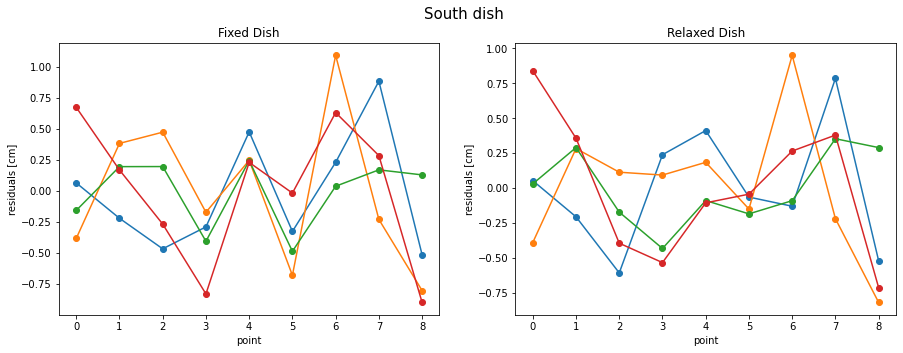

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.plot(S_fitter_T.predict_measurements(S_fit_T.x)-S_measurements,'-o')
ax1.set_title('Fixed Dish')
ax1.set_xlabel('point')
ax1.set_ylabel('residuals [cm]')

ax2.plot(S_fitter_F.predict_measurements(S_fit_F.x)-S_measurements,'-o')
ax2.set_title('Relaxed Dish')
ax2.set_xlabel('point')
ax2.set_ylabel('residuals [cm]')

plt.suptitle('South dish', size = 15)

In [83]:
resid_T = S_fitter_T.predict_measurements(S_fit_T.x)-S_measurements
resid_F = S_fitter_F.predict_measurements(S_fit_F.x)-S_measurements

print('rms_T = ',  np.sqrt(resid_T**2).mean())
print('rms_F = ',  np.sqrt(resid_F**2).mean())

rms_T =  0.3877561907223313
rms_F =  0.32711050020448895


In [85]:
vals_T = S_fit_T.x
errs=np.sqrt((S_fit_T.hess_inv.diagonal())*2)
names = 'f dphi r0 r1 alpha beta gamma xp yp zp'.split()
print('Fixed Dish:')
for n,v,e in zip(names,vals_T, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

print('')
vals_F = S_fit_F.x
print('Relaxed Dish:')
for n,v,e in zip(names,vals_F, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

Fixed Dish:
f = 290.00 +/- 1.41
dphi = 8.00 +/- 1.41
r0 = 70.00 +/- 1.41
r1 = 100.00 +/- 1.41
alpha = 0.41 +/- 0.03
beta = -0.72 +/- 0.03
gamma = 3.81 +/- 0.03
xp = 0.16 +/- 0.04
yp = -10.50 +/- 0.07
zp = 45.20 +/- 0.09

Relaxed Dish:
f = 303.16 +/- 1.41
dphi = 7.88 +/- 1.41
r0 = 72.70 +/- 1.41
r1 = 100.77 +/- 1.41
alpha = 0.41 +/- 0.03
beta = -0.72 +/- 0.03
gamma = 3.27 +/- 0.03
xp = 0.16 +/- 0.04
yp = -14.24 +/- 0.07
zp = 58.99 +/- 0.09


In [86]:
# W dish
# numbers with minus in front of it don't contribute to chi2
W_measurements = np.array([
    [-378.1, 352.3, 371.9, 405.2],
    [339.8, 301.7, 299.1, 336.2],
    [299.8, 273.5, 249.9, 278.1],
    [283.1, 270.8, 226.2, 241.0], # * Panel Damage
    [269.5, 269.3, 228.7, 229.9], # ** major panel-stanchion damage
    [269.9, 280.4, 237.3, 223.8],
    [271.2, 299.2, 274.7, 245.3],
    [298.0, 336.3, 332.4, 293.7],
    [348.4, 386.1, 401.4, 366.9]
])

In [87]:
W_fitter_T = Fitter(W_measurements, start, True)
W_fit_T = W_fitter_T.fit()
print('W_fit (Fixed) = ', W_fit_T.fun)

W_fitter_F = Fitter(W_measurements, start, False)
W_fit_F = W_fitter_F.fit()
print('W_fit (Relaxed) = ', W_fit_F.fun)

W_fit (Fixed) =  480.65715048134496
W_fit (Relaxed) =  227.58732708411586


In [88]:
pred_T = W_fitter_T.predict_measurements(W_fit_T.x)
pred_F = W_fitter_F.predict_measurements(W_fit_F.x)

print('Predicted measurements (True):')
print(pred_T)
print('')
print('Predicted measurements (False):')
print(pred_F)

Predicted measurements (True):
[[388.00868507 352.44635605 371.68642897 405.5651702 ]
 [338.72367238 301.76946666 299.05797164 336.31025204]
 [300.43757519 274.12251917 249.80075768 278.42413619]
 [281.25474447 269.32000861 224.63624393 238.81458569]
 [272.47292939 271.92860881 230.7588329  231.40001713]
 [268.99389395 279.64220487 236.39439284 223.69680642]
 [271.80570237 298.16881979 274.89158038 246.04689737]
 [297.84467268 336.03763845 332.18177007 293.4874494 ]
 [348.06927407 385.8894559  402.20976019 366.07955223]]

Predicted measurements (False):
[[387.72170877 352.49677175 371.43490799 405.01609873]
 [339.25263459 302.24141928 299.95549594 337.2176954 ]
 [299.91941935 272.90631062 249.01620183 278.35745455]
 [282.82307152 269.77737132 224.75632803 240.25916568]
 [271.40102992 270.8378382  229.40089436 230.06554451]
 [269.40485905 281.12602566 237.66272727 223.67545174]
 [270.57134624 297.66485878 274.76212517 245.15038381]
 [298.35658594 336.67624041 333.12977638 294.34878873]


Text(0.5, 0.98, 'West dish')

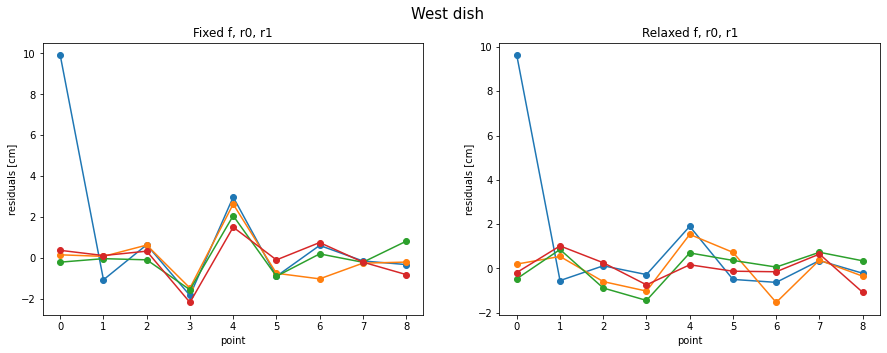

In [89]:
# W_measurements[W_measurements < 0] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.plot(W_fitter_T.predict_measurements(W_fit_T.x)-np.abs(W_measurements),'-o')
ax1.set_title('Fixed f, r0, r1')
ax1.set_xlabel('point')
ax1.set_ylabel('residuals [cm]')

ax2.plot(W_fitter_F.predict_measurements(W_fit_F.x)-np.abs(W_measurements),'-o')
ax2.set_title('Relaxed f, r0, r1')
ax2.set_xlabel('point')
ax2.set_ylabel('residuals [cm]')

plt.suptitle('West dish', size = 15)

In [90]:
W_measurements[W_measurements < 0] = np.nan
resid_T = W_fitter_T.predict_measurements(W_fit_T.x)-W_measurements
resid_F = W_fitter_F.predict_measurements(W_fit_F.x)-W_measurements

print('rms_T = ', np.nanmean(np.sqrt(resid_T**2)))
print('rms_F = ', np.nanmean(np.sqrt(resid_F**2)))

rms_T =  0.805984571222191
rms_F =  0.6181260706036921


In [91]:
vals_T = W_fit_T.x
errs=np.sqrt((W_fit_T.hess_inv.diagonal())*2)
names = 'f dphi r0 r1 alpha beta gamma xp yp zp'.split()
print('Fixed Dish:')
for n,v,e in zip(names,vals_T, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

print('')
vals_F = W_fit_F.x
print('Relaxed Dish:')
for n,v,e in zip(names,vals_F, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

Fixed Dish:
f = 290.00 +/- 1.41
dphi = 8.00 +/- 1.41
r0 = 70.00 +/- 1.41
r1 = 100.00 +/- 1.41
alpha = -1.13 +/- 0.10
beta = 1.31 +/- 0.02
gamma = 1.44 +/- 0.01
xp = -3.68 +/- 0.01
yp = -18.93 +/- 0.05
zp = 44.09 +/- 0.04

Relaxed Dish:
f = 384.91 +/- 1.41
dphi = 7.57 +/- 1.41
r0 = 80.73 +/- 1.41
r1 = 101.69 +/- 1.41
alpha = -1.19 +/- 0.10
beta = 1.33 +/- 0.02
gamma = -3.78 +/- 0.01
xp = -3.64 +/- 0.01
yp = -49.12 +/- 0.05
zp = 136.84 +/- 0.04
